In [ ]:
# pip install sentence-transformers
#pip install pillow
# pip install torchvision
# pip install transformers
# pip install umap-learn

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import json
import torch
import requests
import re
import ast
import umap
from transformers import CLIPProcessor, CLIPModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from sklearn.neighbors import NearestNeighbors


### Load Json Datafile

In [5]:

#Import datafile
file_path = "meta_AMAZON_FASHION.json"

records = []
bad_lines = 0

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            bad_lines += 1
            continue  # skip malformed lines

print(f"Loaded {len(records)} records (skipped {bad_lines} bad lines)")

# Convert to DataFrame
df = pd.DataFrame(records)

print("Rows:", df.shape[0], "Columns:", df.shape[1])


Loaded 186637 records (skipped 0 bad lines)
Rows: 186637 Columns: 16


In [7]:
df.head()

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.tail()

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
186632,JT Women's Elegant Off Shoulder Chiffon Maxi L...,JT,NaN,"9,835,890inClothing,ShoesJewelry(",5 star,B01HJGXL4O,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186633,Microcosm Retro Vintage Black Crochet Lace One...,Microcosm,[Package Dimensions:\n \n7....,"11,390,771inClothing,ShoesJewelry(",5 star5 star (0%),B01HJHF97K,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186634,Lookatool Classic Plain Vintage Army Military ...,Lookatool,"[Cotton+Polyester, Imported, Item type:Basebal...","972,275inClothing,ShoesJewelry(",5 star,B01HJGJ9LS,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,$8.53,"[B00XLECZMS, B0018MQAOY, B00N833I4Q, B074DQSPP...","[B07BHQ1FXL, B00XLECZMS, B07CJWM5WY, B07CS97C1...","class=""a-normal a-align-center a-spacing-smal...",NaN,NaN,NaN
186635,Edith Windsor Women's Deep V-neck Beaded Sequi...,Edith Windsor,[Product Dimensions:\n \n9....,"1,964,585inClothing,ShoesJewelry(",5 star,B01HJHTH5U,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,[B077ZLGMJ3],NaN,NaN,NaN,NaN
186636,Aeropostale Women's Sun & Waves Crop Cami L Gr...,NaN,[Product Dimensions:\n \n5 ...,"9,379,125inClothing,ShoesJewelry(",5 star,B01HJFNU7S,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print("Duplicate ASINs:", df["asin"].duplicated().sum())

Duplicate ASINs: 443


In [13]:
df = df.drop_duplicates(subset=["asin"], keep="first")

# Sentense Hybrid Recommender Model (Semantic + Numeric Features)

### Data Cleaning and preprocessing

In [15]:
df_hybrid = df.copy()

# Keep only rows where BOTH brand and price exist
df_hybrid = df_hybrid[df_hybrid['brand'].notna() & df_hybrid['price'].notna()].copy()

# Clean price: remove $, convert to float
df_hybrid['price'] = df_hybrid['price'].replace(r'[$,]', '', regex=True)
df_hybrid['price'] = pd.to_numeric(df_hybrid['price'], errors='coerce')

# After conversion, drop rows where price is NaN
df_hybrid = df_hybrid.dropna(subset=['price']).reset_index(drop=True)

print(df_hybrid.shape)


(12143, 16)


### Encode Brand

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_hybrid['brand_enc'] = le.fit_transform(df_hybrid['brand'])

In [19]:
#Clean Rank
df_hybrid['rank_numeric'] = df_hybrid['rank'].str.extract(r'(\d+)').astype(float)
df_hybrid['rank_numeric'] = df_hybrid['rank_numeric'].fillna(df_hybrid['rank_numeric'].median())


### Scale Numeric Features

In [21]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np

numeric_features = df_hybrid[['brand_enc','price','rank_numeric']].values

scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(numeric_features)

# Apply low weight
numeric_scaled = numeric_scaled * 0.1

In [23]:
df_hybrid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12143 entries, 0 to 12142
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            12143 non-null  object 
 1   brand            12143 non-null  object 
 2   feature          11985 non-null  object 
 3   rank             11884 non-null  object 
 4   date             11460 non-null  object 
 5   asin             12143 non-null  object 
 6   imageURL         7901 non-null   object 
 7   imageURLHighRes  7901 non-null   object 
 8   description      5546 non-null   object 
 9   price            12143 non-null  float64
 10  also_view        5213 non-null   object 
 11  also_buy         3741 non-null   object 
 12  fit              798 non-null    object 
 13  details          303 non-null    object 
 14  similar_item     228 non-null    object 
 15  tech1            63 non-null     object 
 16  brand_enc        12143 non-null  int32  
 17  rank_numeric

### Generate Sentence-BERT Semantic Embeddings(Title+Desciption)

In [25]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

title_embeds = model.encode(
    df_hybrid['title'].fillna(""),
    convert_to_numpy=True,
    show_progress_bar=False
)

df_hybrid['description'] = df_hybrid['description'].astype(str)


desc_embeds = model.encode(
    df_hybrid['description'],
    convert_to_numpy=True,
    show_progress_bar=False
)


### Text-Only CLIP Embeddings

In [27]:
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def clip_clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+', '', text)        # remove URLs
    text = text.replace('[', ' ').replace(']', ' ')
    return text[:200]                          # safe truncation

clip_texts = ["a product photo of " + clip_clean_text(t)
              for t in df_hybrid['title'].fillna("")]

clip_text_embeds = []

batch_size = 32
for start in range(0, len(clip_texts), batch_size):
    batch = clip_texts[start:start+batch_size]

    inputs = clip_processor(
        text=batch,
        return_tensors="pt",
        padding=True,
        truncation=True,      # prevents sequence too long error
        max_length=77         # CLIP’s maximum
    )
    
    with torch.no_grad():
        embeds = clip_model.get_text_features(**inputs)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)
        clip_text_embeds.append(embeds.cpu().numpy())

clip_text_embeds = np.vstack(clip_text_embeds)
print("CLIP text embeddings shape:", clip_text_embeds.shape)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP text embeddings shape: (12143, 512)


In [29]:
def l2_norm(x):
    return x / np.linalg.norm(x, axis=1, keepdims=True)

title_embeds = l2_norm(title_embeds)
desc_embeds = l2_norm(desc_embeds)
clip_text_embeds = l2_norm(clip_text_embeds)


### Clean also_view & also_buy features for Evaluation

In [31]:
def clean_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []


In [33]:
df_hybrid['also_view_list'] = df_hybrid['also_view'].apply(clean_list)
df_hybrid['also_buy_list']  = df_hybrid['also_buy'].apply(clean_list)


In [35]:
def evaluate_recommender(sample_size, k, nn_model, hybrid_matrix):
    indices = np.random.choice(len(df_hybrid), sample_size, replace=False)

    hit_list, prec_list, rec_list = [], [], []

    for idx in indices:
        asin = df_hybrid.iloc[idx]['asin']
        
        # get recommendations from custom model + matrix
        distances, rec_idx = nn_model.kneighbors(
            [hybrid_matrix[idx]],
            n_neighbors=k+1
        )
        
        rec_asins = set(df_hybrid.iloc[rec_idx[0][1:]]["asin"].tolist())

        # ground truth relevance
        view = set(df_hybrid.iloc[idx]["also_view_list"])
        buy  = set(df_hybrid.iloc[idx]["also_buy_list"])
        relevant = view.union(buy)
        if len(relevant)==0:
            continue
        
        hits = rec_asins.intersection(relevant)
        
        hit_list.append(1 if len(hits)>0 else 0)
        prec_list.append(len(hits)/k)
        rec_list.append(len(hits)/len(relevant))
    
    return {
        "HitRate@5": np.mean(hit_list),
        "Precision@5": np.mean(prec_list),
        "Recall@5": np.mean(rec_list),
    }


In [37]:
import itertools
import random

weight_space = {
    "w_title":  [0.3, 0.4, 0.5, 0.6],
    "w_desc":   [0.1, 0.2, 0.3, 0.4],
    "w_clip":   [0.1, 0.2, 0.3],
    "w_num":    [0.05, 0.1, 0.15]
}


### Build Hybrid Feature Matrix

In [ ]:
# hybrid_matrix = np.hstack([
#     title_embeds * 0.45,        # title meaning
#     desc_embeds * 0.30,        # detailed meaning
#     numeric_scaled * 0.05,         # brand + price + rank
#     clip_text_embeds * 0.20        # visual semantics
# ])

In [39]:
def build_hybrid_matrix(w):
    return np.hstack([
        title_embeds * w["w_title"],
        desc_embeds  * w["w_desc"],
        clip_text_embeds * w["w_clip"],
        numeric_scaled * w["w_num"]
    ])


In [41]:
def random_search_weights(n_trials=15):
    best_score = -1
    best_weights = None
    
    for _ in range(n_trials):
        
        # Sample random weights
        w = {
            "w_title": random.choice(weight_space["w_title"]),
            "w_desc":  random.choice(weight_space["w_desc"]),
            "w_clip":  random.choice(weight_space["w_clip"]),
            "w_num":   random.choice(weight_space["w_num"]),
        }
        
        print("\nTesting weights:", w)
        
        # Build matrix with this combination
        temp_matrix = build_hybrid_matrix(w)
        
        # Fit model
        temp_nn = NearestNeighbors(metric="cosine", algorithm="brute")
        temp_nn.fit(temp_matrix)
        
        # Lightweight evaluation on 80 samples
        score = evaluate_recommender(
            sample_size=80, 
            k=5, 
            nn_model=temp_nn, 
            hybrid_matrix=temp_matrix
        )["Precision@5"]
        
        print("Precision@5:", score)
        
        if score > best_score:
            best_score = score
            best_weights = w
    
    return best_weights, best_score


In [43]:
best_w, best_score = random_search_weights(n_trials=20)
print("\nBest weights:", best_w)
print("Best Precision@5:", best_score)


Testing weights: {'w_title': 0.4, 'w_desc': 0.3, 'w_clip': 0.3, 'w_num': 0.15}
Precision@5: 0.021621621621621623

Testing weights: {'w_title': 0.6, 'w_desc': 0.4, 'w_clip': 0.3, 'w_num': 0.05}
Precision@5: 0.03225806451612903

Testing weights: {'w_title': 0.3, 'w_desc': 0.3, 'w_clip': 0.1, 'w_num': 0.15}
Precision@5: 0.005128205128205128

Testing weights: {'w_title': 0.6, 'w_desc': 0.4, 'w_clip': 0.2, 'w_num': 0.15}
Precision@5: 0.03333333333333334

Testing weights: {'w_title': 0.4, 'w_desc': 0.1, 'w_clip': 0.1, 'w_num': 0.15}
Precision@5: 0.03111111111111111

Testing weights: {'w_title': 0.4, 'w_desc': 0.2, 'w_clip': 0.2, 'w_num': 0.1}
Precision@5: 0.01951219512195122

Testing weights: {'w_title': 0.5, 'w_desc': 0.1, 'w_clip': 0.2, 'w_num': 0.15}
Precision@5: 0.029268292682926828

Testing weights: {'w_title': 0.3, 'w_desc': 0.4, 'w_clip': 0.2, 'w_num': 0.05}
Precision@5: 0.0368421052631579

Testing weights: {'w_title': 0.3, 'w_desc': 0.3, 'w_clip': 0.3, 'w_num': 0.15}
Precision@5: 0.

best_w, best_score = random_search_weights(n_trials=20)
print("\nBest weights:", best_w)
print("Best Precision@5:", best_score)

### Fit Nearest Neighbors Model

In [ ]:
# from sklearn.neighbors import NearestNeighbors

# nn_model = NearestNeighbors(
#     n_neighbors=10,
#     metric='cosine',
#     algorithm='brute'
# )
# # nn_model.fit(hybrid_matrix)


In [44]:
hybrid_matrix = build_hybrid_matrix(best_w)

nn_model = NearestNeighbors(metric="cosine", algorithm="brute")
nn_model.fit(hybrid_matrix)

,n_neighbors,5
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


### Hybrid Recommender Function (BERT+ brand + price+rank)

In [47]:
def recommend_hybrid_bert(asin, n_recommend=5):
    if asin not in set(df_hybrid['asin']):
        print("ASIN not in hybrid dataset.")
        return pd.DataFrame()

    idx = df_hybrid.index[df_hybrid['asin'] == asin][0]

    distances, indices = nn_model.kneighbors(
        [hybrid_matrix[idx]],
        n_neighbors=n_recommend + 1
    )

    results = df_hybrid.iloc[indices[0][1:]].copy()
    results['distance'] = distances[0][1:]

    return results[['asin', 'title', 'brand', 'price','rank_numeric', 'distance']]


In [49]:
sample_asin = df_hybrid['asin'].iloc[45]
print("INPUT PRODUCT:", df_hybrid.loc[df_hybrid['asin']==sample_asin, 'title'].values[0])

recommend_hybrid_bert(sample_asin, 5)



INPUT PRODUCT: Onimusha: Onimusha Logo Black Beanie


,asin,title,brand,price,rank_numeric,distance
10316,B01AZN4C1E,Phi Beta Sigma Beanie - Black,Big Boy Headgear,13.88,798.0,0.396706
5067,B00NNLHDDA,Emperor Logo Official New Black Beanie Hat,Emperor,19.99,1.0,0.421441
3119,B00GKOT2JK,Yo Gabba Gabba - Brobee Big Face Beanie,Yo Gabba Gabba,16.94,2.0,0.458182
6651,B00UXZ74KG,Rush Beanie Hat Cap Classic Band Logo Official...,Rush by Gordon Rush,12.00,848.0,0.461615
6652,B00UXZ703W,Behemoth Logo Official New Beanie Hat,Behemoth,19.99,1.0,0.465330


### Evaluation

#### Mean Similarity (Higher = More Relevant Recommendations)

In [51]:
def mean_similarity(recommendations):
    sims = 1 - recommendations['distance']   # convert distance → similarity
    return sims.mean()

In [53]:
recs = recommend_hybrid_bert(sample_asin, 5)
print("Mean Similarity:", mean_similarity(recs))

Mean Similarity: 0.5593451950049674


#### Coverage (Higher = Recommender Reaches More of the Catalog)

In [55]:
def coverage(df, nn_model, hybrid_matrix, sample_size=500):
    indices = np.random.choice(len(df), sample_size, replace=False)
    recommended = set()

    for idx in indices:
        distances, nn_idx = nn_model.kneighbors(
            [hybrid_matrix[idx]], 
            n_neighbors=6
        )
        recommended.update(nn_idx[0][1:])

    return len(recommended) / len(df)


In [57]:
print("Coverage:", coverage(df_hybrid, nn_model, hybrid_matrix))

Coverage: 0.17763320431524335


#### Diversity (Higher = Recommendations Not Too Similar to Each Other)

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

def diversity(recommendations):
    idx_list = recommendations.index.tolist()
    mat = cosine_similarity(hybrid_matrix[idx_list])
    
    # Remove diagonal (self-similarity)
    mask = ~np.eye(len(mat), dtype=bool)
    sims = mat[mask]
    
    return 1 - sims.mean()   # higher = more diverse


In [61]:
print("Diversity:", diversity(recs))

Diversity: 0.4648887511892168


#### Novelty Score (Higher = Recommender Suggests Non-Obvious Items)

In [63]:
def novelty(recommendations):
    return recommendations['distance'].mean()   # higher distance = more novel
print("Novelty:", novelty(recs))

Novelty: 0.4406548049950326


#### Evaluation for a Single Item

In [65]:
def evaluate_item(idx, k=5):
    asin = df_hybrid.iloc[idx]['asin']

    # Get top-k recommendations
    recs = recommend_hybrid_bert(asin, k)
    recommended_asins = set(recs['asin'].tolist())

    # Ground-truth relevance
    also_view = set(df_hybrid.iloc[idx]['also_view_list'])
    also_buy  = set(df_hybrid.iloc[idx]['also_buy_list'])
    relevant = also_view.union(also_buy)

    # If no ground truth exists → skip
    if len(relevant) == 0:
        return None

    # Hits = intersection of recommended and ground truth
    hits = recommended_asins.intersection(relevant)

    # Metrics
    hit_rate  = 1 if len(hits) > 0 else 0
    precision = len(hits) / k
    recall    = len(hits) / len(relevant)

    return hit_rate, precision, recall


#### Evaluation Over Many Items

In [67]:

def evaluate_recommender(sample_size=300, k=5):
    indices = np.random.choice(len(df_hybrid), sample_size, replace=False)

    hit_list = []
    prec_list = []
    rec_list = []

    for idx in indices:
        result = evaluate_item(idx, k)

        if result is None:
            continue

        hit, precision, recall = result
        hit_list.append(hit)
        prec_list.append(precision)
        rec_list.append(recall)

    return {
        "HitRate@5": np.mean(hit_list),
        "Precision@5": np.mean(prec_list),
        "Recall@5": np.mean(rec_list)
    }


In [69]:
metrics = evaluate_recommender(sample_size=400, k=5)
print(metrics)

{'HitRate@5': 0.15656565656565657, 'Precision@5': 0.04646464646464646, 'Recall@5': 0.021263034800205773}


### UMAP 2D projection

In [71]:
import umap
import matplotlib.pyplot as plt

# reduce hybrid matrix (very large) into 2D
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

embedding_2d = umap_model.fit_transform(hybrid_matrix)


### Color by brand (top 20 brands only)

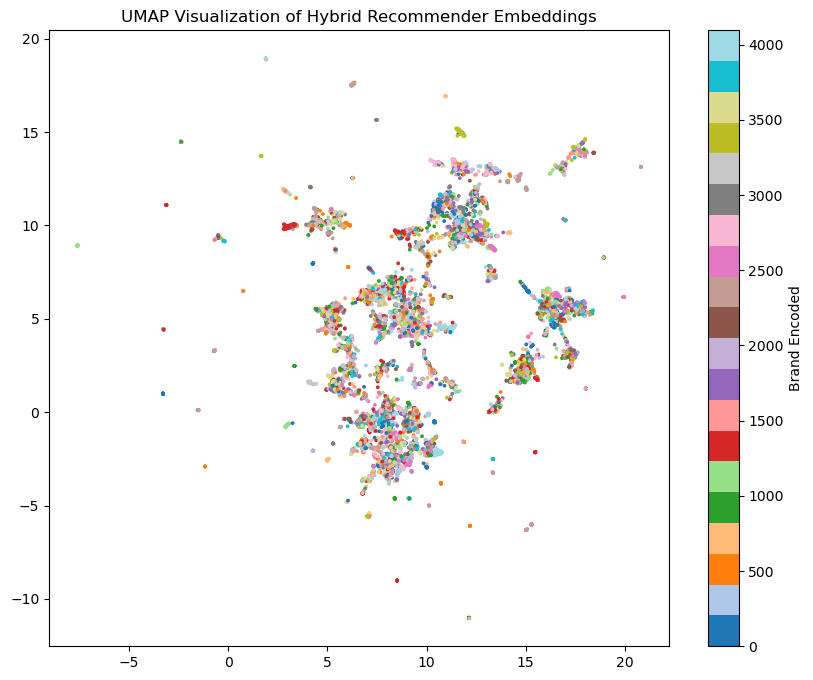

In [73]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=df_hybrid['brand_enc'],
    s=3,
    cmap='tab20'
)
plt.colorbar(scatter, label='Brand Encoded')
plt.title("UMAP Visualization of Hybrid Recommender Embeddings")
plt.show()


### Color by price (gives economic clustering)

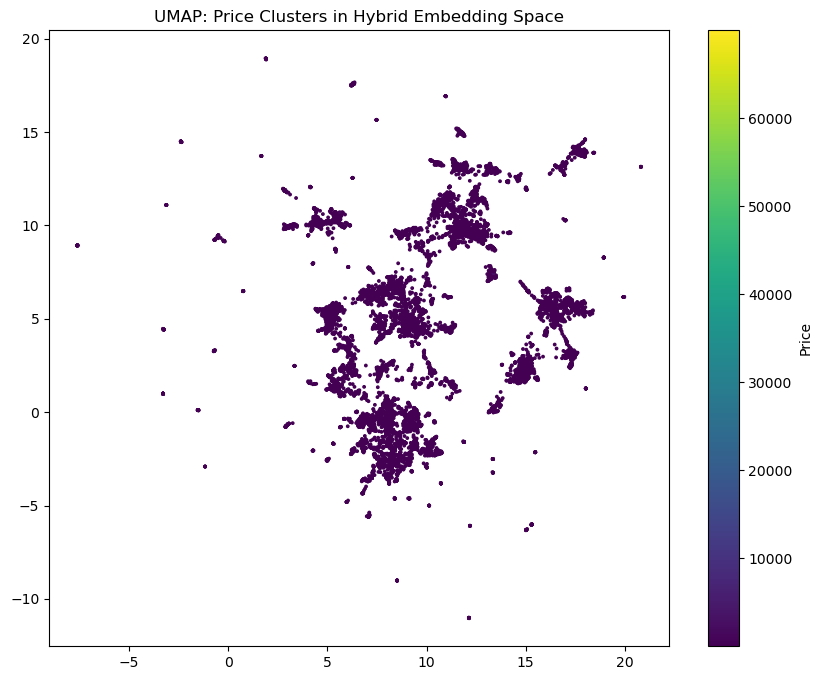

In [75]:
plt.figure(figsize=(10, 8))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=df_hybrid['price'],
    s=3,
    cmap='viridis'
)
plt.colorbar(label='Price')
plt.title("UMAP: Price Clusters in Hybrid Embedding Space")
plt.show()
